In [4]:
import math
import os
import pandas as pd
from itertools import combinations
import scipy.cluster.hierarchy as sch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hypergeom
from sklearn.preprocessing import StandardScaler
from collections import Counter
from scipy.cluster import hierarchy
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import xlsxwriter

In [2]:
# Read psychiatric files into dataframes
adhd = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_ADHD.txt', sep='\t')
asd = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_ASD.txt', sep='\t')
anorexia = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_ANOREXIA.txt', sep='\t')
anxiety = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_ANXIETY.txt', sep='\t')
aud = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_AUD.txt', sep='\t')
bpd = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_BPD.txt', sep='\t')
cud = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_CUD.txt', sep='\t')
hoarding = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_HOARDING.txt', sep='\t')
mdd = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_MDD.txt', sep='\t')
ocd = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_OCD.txt', sep='\t')
#od = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_OD.txt', sep='\t')
ptsd = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_PTSD.txt', sep='\t' )
scz = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_SCZ.txt', sep='\t')
tourette = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_TOURETTES.txt', sep='\t')



In [ ]:
# Specify the directory path where your files are located
directory_path = 'FUMA_downloads_all_tissue/SNPs'

# Initialize an empty list to store DataFrames
df_list = []

# Initialize an empty list to store disorder names
disorder_names = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.txt'):  # Process only .txt files
        # Extract disorder name from the filename
        disorder_name = filename.split('_')[1].split('.')[0]
        disorder_names.append(disorder_name)

        # Read the file as a DataFrame
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path, sep='\t')

        # Add a column with the disorder name
        df['disorder'] = disorder_name

        # Append the DataFrame to the list
        df_list.append(df)

In [9]:
# Specify the directory path where your files are located
directory_path = 'FUMA_downloads_all_tissue/eQTLs'

# Initialize an empty list to store DataFrames
df_list = []

# Initialize an empty list to store disorder names
disorder_names = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.txt'):  # Process only .txt files
        # Extract disorder name from the filename
        disorder_name = filename.split('_')[1].split('.')[0]
        disorder_names.append(disorder_name)

        # Read the file as a DataFrame
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path, sep='\t')

        # Add a column with the disorder name
        df['disorder'] = disorder_name

        # Append the DataFrame to the list
        df_list.append(df)

C:\Users\annei\AppData\Local\Temp\ipykernel_17344\538097247.py:19: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')
C:\Users\annei\AppData\Local\Temp\ipykernel_17344\538097247.py:19: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')
C:\Users\annei\AppData\Local\Temp\ipykernel_17344\538097247.py:19: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')
C:\Users\annei\AppData\Local\Temp\ipykernel_17344\538097247.py:19: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')
C:\Users\annei\AppData\Local\Temp\ipykernel_17344\538097247.py:19: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
 

In [ ]:
# sjogrens = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_SJOGRENS.txt', sep='\t')
# lupus = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_LUPUS.txt', sep='\t')
# biliary_chorrhosis = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_BILIARY.txt', sep='\t')
# myasthenia = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_MYASTHENIA.txt', sep='\t')
# rh_arthritis = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_ARTHRITIS.txt', sep='\t')
# ms = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_MS.txt', sep='\t')
# parkinsons = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_PARKINSONS.txt', sep='\t')
# migraine = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_MIGRAINE.txt', sep='\t')
# fibromyalgia = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_FIBROMYLGIA.txt', sep='\t')
# fatigue = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_FATIGUE.txt', sep='\t')
# ibs = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_IBS.txt', sep='\t')
# gout = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_GOUT.txt', sep='\t')

In [4]:
# Lists of all dataframes
psych = [adhd, asd, anorexia, anxiety, aud, bpd, cud, hoarding, mdd, ocd, ptsd, scz, tourette]
# other = [epilepsy, sjogrens, lupus, biliary_chorrhosis, myasthenia, rh_arthritis, ms, parkinsons,migraine, fibromyalgia, fatigue, ibs, gout]
#lists of disorder names
psych_names = ['adhd', 'asd', 'anorexia', 'anxiety', 'aud', 'bpd', 'cud', 'hoarding', 'mdd', 'ocd', 'ptsd', 'scz', 'tourette']
#other_names = ['epilepsy','sjogrens', 'lupus', 'biliary_chorrhosis', 'myasthenia', 'rh_arthritis', 'ms', 'parkinsons','migraine', 'fibromyalgia', 'fatigue', 'ibs', 'gout']

In [11]:

    
#Add a column with the name of the disorder in each dataframe
for df, name in zip(psych, psych_names):
    df['disorder'] = name


new_df_list =[]
# Removing rows with NaN values and selecting relevant columns
for df in psych:
    df.dropna(subset=['gwasP'], inplace=True)
    df = df[['uniqID', 'rsID', 'gwasP', 'disorder']]
    df.reset_index(drop=True,inplace=True)
    new_df_list.append(df)
    



In [13]:
new_df_list[3].head()

,uniqID,rsID,gwasP,disorder
0,2:180616609:A:C,rs356407,7.328000e-06,anxiety
1,3:101684480:C:T,rs58365525,2.955000e-08,anxiety
2,3:101687866:C:T,rs7639702,3.409000e-08,anxiety
3,3:101688697:C:T,rs6780912,1.266000e-07,anxiety
4,3:101688818:G:T,rs6796400,2.526000e-08,anxiety


In [16]:
# select top 500 SNPs ranked by significance
top_snp_list = []
for df in new_df_list:
    sorted = df.sort_values(by=['gwasP'])
    top_snps = sorted.iloc[:500]
    top_snps.reset_index(drop=True,inplace=True)
    top_snp_list.append(top_snps)

In [19]:
#Function to make binary matrix of SNPs and disorders
def make_binary_SNPs_matrix(df_list):
    concatenated= pd.concat(df_list)
    df = concatenated[['rsID', 'disorder']]
    return df.pivot_table(index='rsID', columns='disorder', aggfunc=lambda x: 1, fill_value=0)
    

In [20]:
#Make a binary matrix of all snps to find out how many there are in each disorder
snps_psych_binary = make_binary_SNPs_matrix(new_df_list)
# snps_other_binary = make_binary_SNPs_matrix(dfs_other)
# print('The number of SNPs shared between at least 2 disorders: ', (snps_psych_binary.sum(axis=1) >= 2).sum())
print(snps_psych_binary.sum(axis=0))

disorder
adhd         7018
anorexia     2562
anxiety        84
asd          4006
aud          5984
bpd         27077
cud           719
hoarding       79
mdd         15332
ocd           130
ptsd          186
scz         41691
tourette      292
dtype: int64


In [11]:
# Function to make binary matrix of genes and disorders
def make_binary_genes_matrix(df_list):
    concatenated= pd.concat(df_list)
    df = concatenated[['symbol', 'disorder']]
    return df.pivot_table(index='symbol', columns='disorder', aggfunc=lambda x: 1, fill_value=0)

In [12]:
genes_binary = make_binary_genes_matrix(new_df_list)

In [35]:
genes_binary.to_excel('genes_disorders.xlsx')

In [13]:
print(genes_binary.sum(axis=0))

disorder
ADHD          1135
ANOREXIA       474
ANXIETY         43
ARTHRITIS     2660
ASD            308
AUD            678
BILIARY       2434
BPD           2440
CUD            308
FATIGUE         63
GOUT            63
HOARDING        42
IBS            470
LUPUS         1888
MDD           1485
MIGRAINE       566
MS             722
MYASTHENIA     502
OCD             44
PARKINSONS     136
PTSD           128
SCZ           4149
SJOGRENS       390
TOURETTES      164
dtype: int64


In [22]:
print('The number of SNPs shared between at least 2 psychiatric disorders: ',(snps_psych_binary.sum(axis=1) >= 2).sum())
# print('The number of genes shared between at least 2 psychiatric disorders: ',(top_psych_genes.sum(axis=1) >= 2).sum())
# print('The number of SNPs shared between at least 2 other disorders: ',(top_other_snps.sum(axis=1) >= 2).sum())
# print('The number of genes shared between at least 2 other disorders: ',(top_other_genes.sum(axis=1) >= 2).sum())
# print('The number of SNPs shared between at least 2 disorders: ',(top_all_snps.sum(axis=1) >= 2).sum())
# print('The number of genes shared between at least 2 disorders: ',(top_all_genes.sum(axis=1) >= 2).sum())

The number of SNPs shared between at least 2 psychiatric disorders:  13393


The number of SNPs shared between at least 2 psychiatric disorders:  34


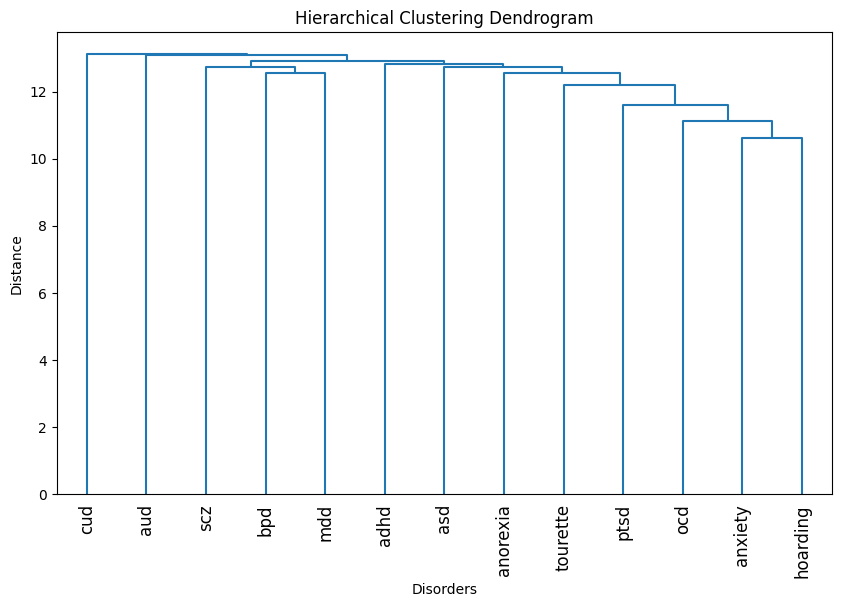

The number of SNPs shared between at least 2 psychiatric disorders:  34


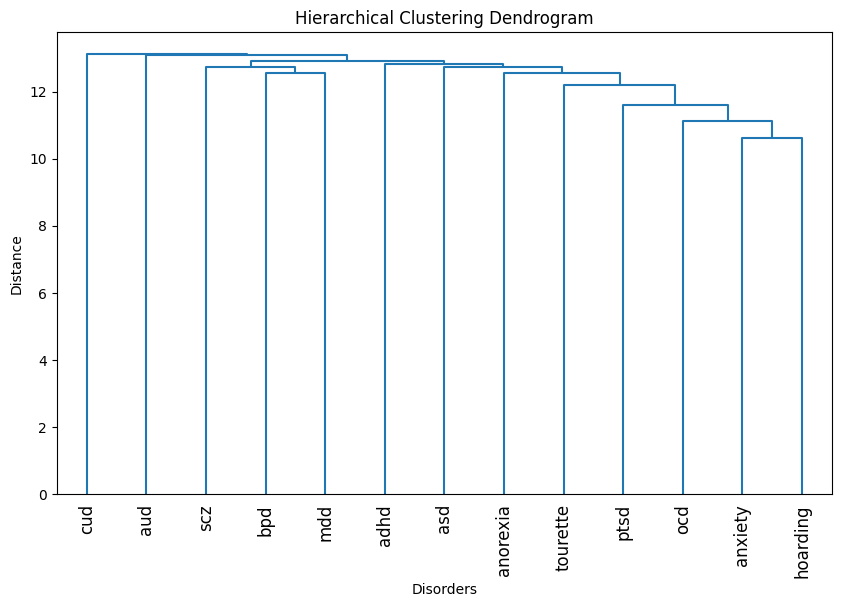

The number of SNPs shared between at least 2 psychiatric disorders:  34


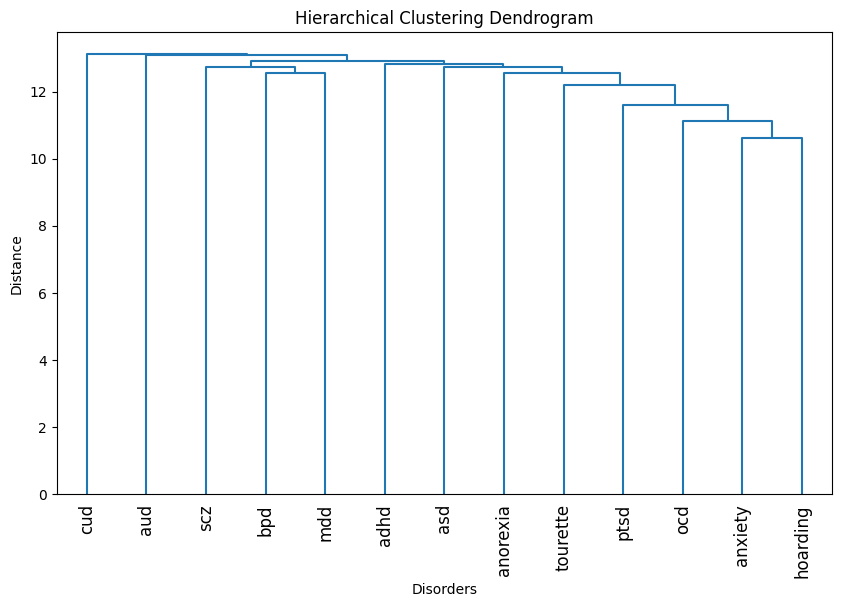

The number of SNPs shared between at least 2 psychiatric disorders:  34


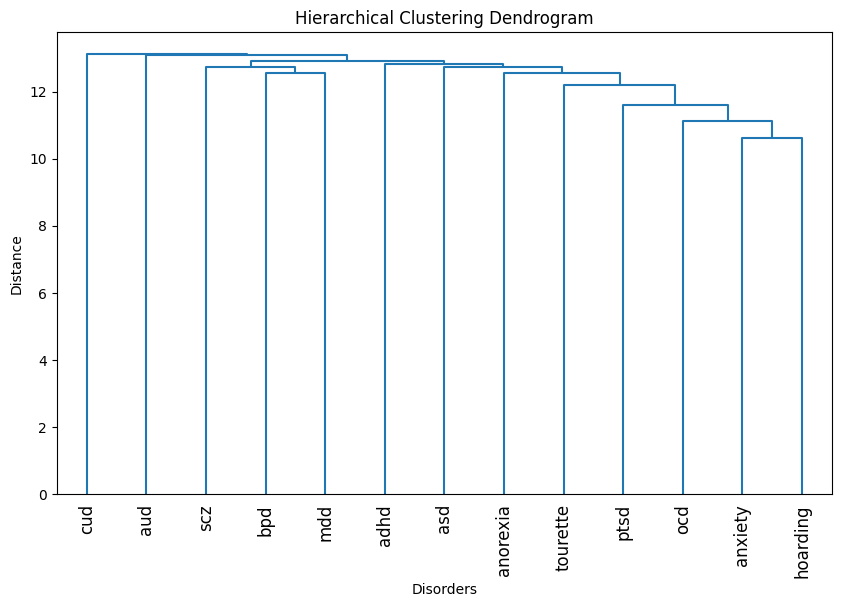

The number of SNPs shared between at least 2 psychiatric disorders:  34


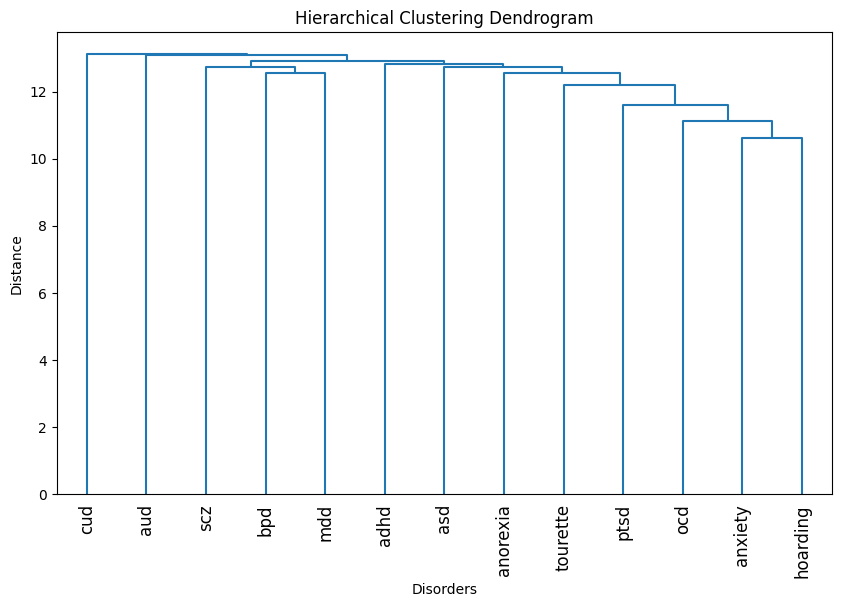

The number of SNPs shared between at least 2 psychiatric disorders:  34


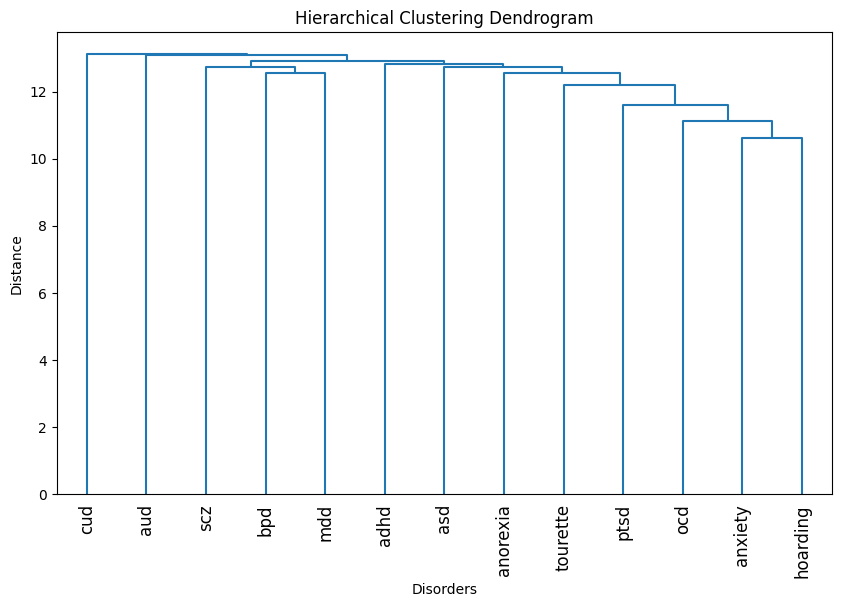

The number of SNPs shared between at least 2 psychiatric disorders:  34


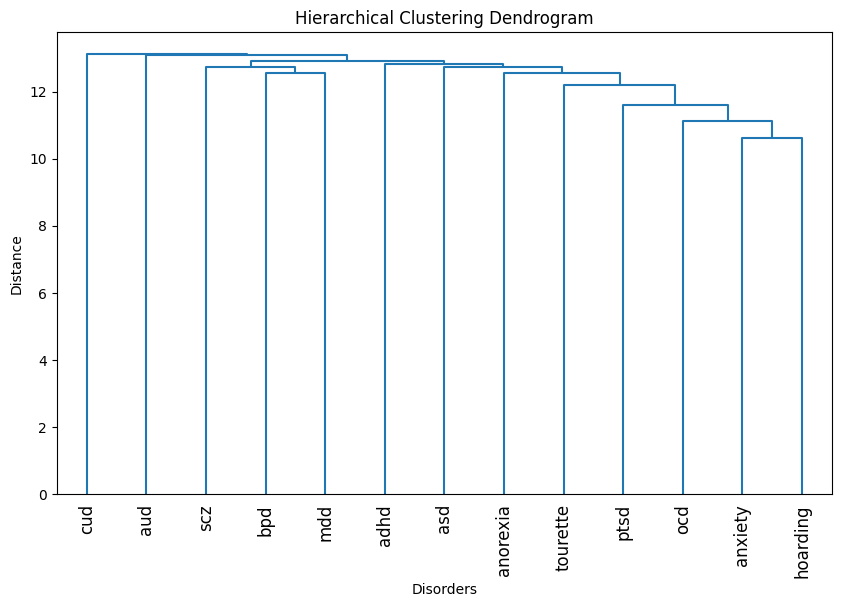

The number of SNPs shared between at least 2 psychiatric disorders:  34


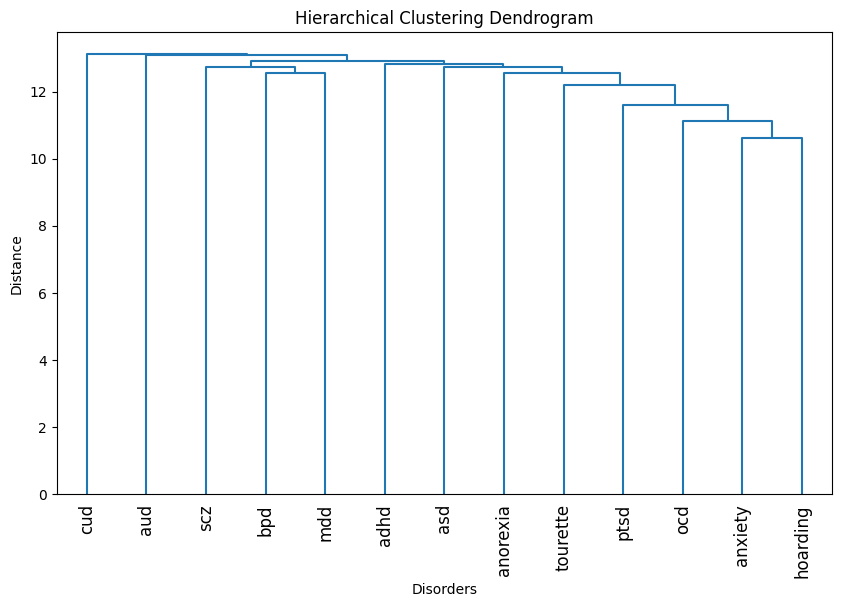

The number of SNPs shared between at least 2 psychiatric disorders:  34


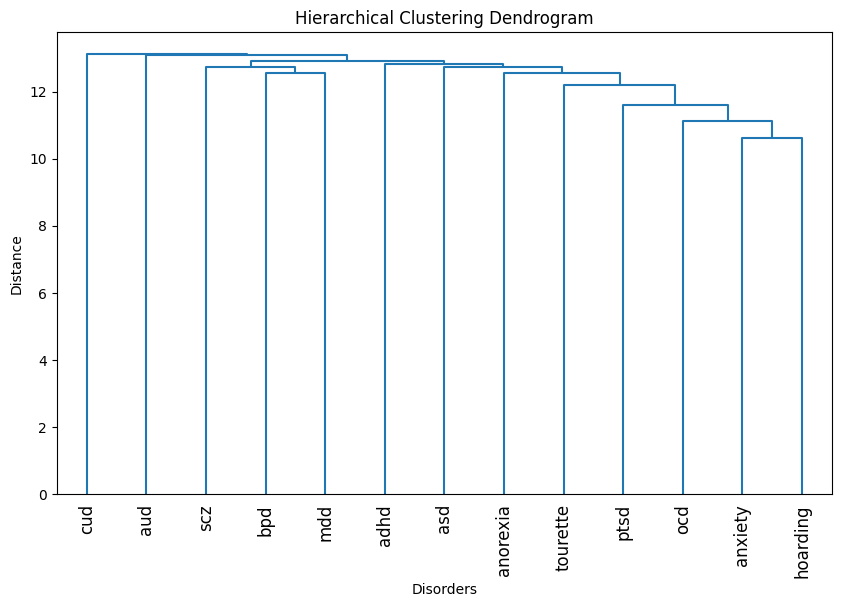

The number of SNPs shared between at least 2 psychiatric disorders:  34


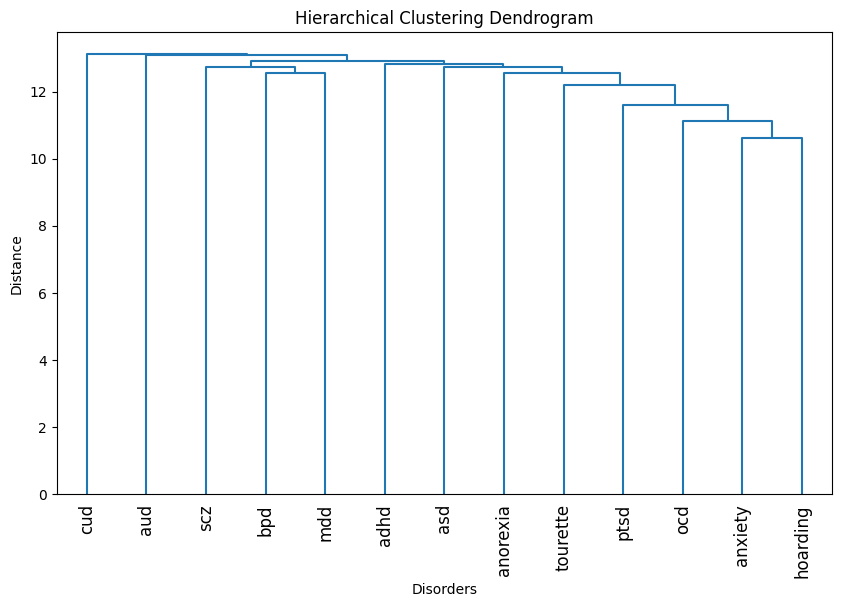

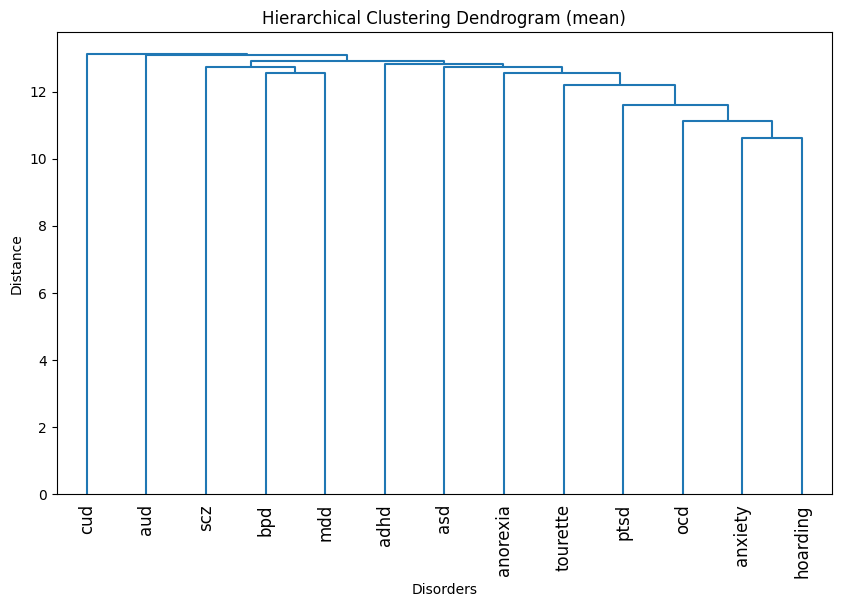

In [71]:
#  randomly select a given number of SNPs
all_linkage = []

for _ in range(10):
    psych_sampled_dfs = []
    for df in top_snp_list:
        sampled = df.sample(100, replace=True, random_state=42)
        sampled.reset_index(inplace=True, drop=True)
        # reset index
        #sampled_df.reset_index()
        psych_sampled_dfs.append(sampled)

    psych_sampled_binary = make_binary_SNPs_matrix(psych_sampled_dfs)
    print('The number of SNPs shared between at least 2 psychiatric disorders: ',(psych_sampled_binary.sum(axis=1) >= 2).sum())
    #hierarchical clustering
    linkage_matrix = hierarchy.linkage(psych_sampled_binary.T, method='average')
    all_linkage.append(linkage_matrix)

    # Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram = hierarchy.dendrogram(linkage_matrix, labels=psych_sampled_binary.columns)
    plt.xlabel('Disorders')
    plt.ylabel('Distance')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xticks(rotation=90)
    plt.show()

   

mean_linkage = np.mean(all_linkage, axis=0)

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(mean_linkage, labels=psych_sampled_binary.columns)
plt.xlabel('Disorders')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram (mean)')
plt.xticks(rotation=90)
plt.show()

The number of SNPs shared between at least 2 psychiatric disorders:  37


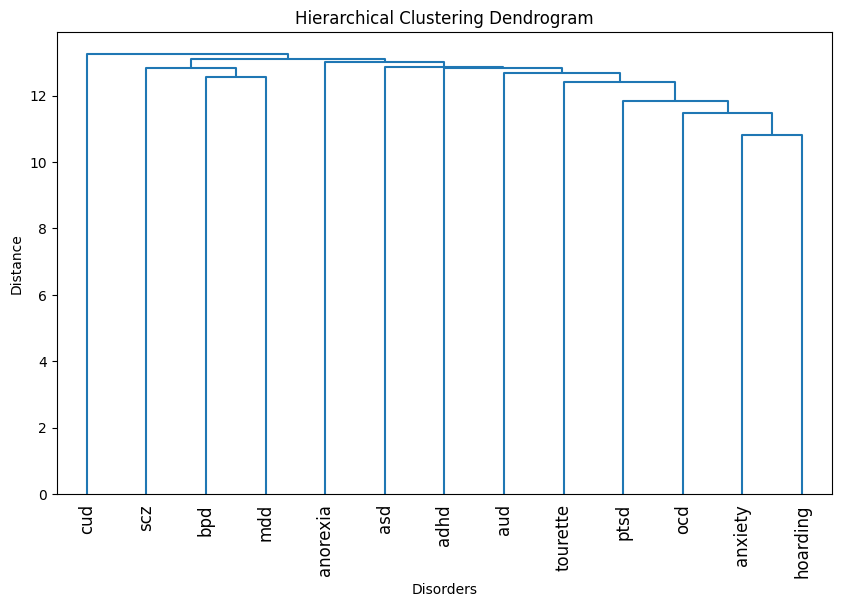

In [17]:
#function to find the overlaps in SNPs and genes

def find_overlaps(binary_matrix):

    overlaps = []
    
    for index, row in binary_matrix.iterrows():
        ones = [col for col, val in row.items() if val == 1]
        
        if len(ones) >= 2:
            overlaps.append((index, ones))
    return overlaps      


In [18]:
overlapping_genes = find_overlaps(genes_binary)

In [ ]:
overlap_snps_psych = find_overlaps(top_psych_snps)
# overlap_genes_psych = find_overlaps(top_psych_genes)
# overlap_snps_other = find_overlaps(top_other_snps)
# overlap_genes_other = find_overlaps(top_other_genes)
# overlap_snps_all = find_overlaps(top_all_snps)
# overlap_genes_all = find_overlaps(top_all_genes)

In [ ]:
# function to find which snps overlaps in which disorders
def show_snps_overlaps(list_of_snps):

    #snp_list = []
    for snps, disorders in list_of_snps:
        #snp_list.append(snps)
        print(f'{snps} overlaps in {disorders}')

In [19]:
#function to find which genes overlaps in which disorders
def show_gene_overlaps(list_of_genes):
    #gene_list = []
    for gene, disorders in list_of_genes:
        #gene_list.append(gene)
        print(f'{gene} overlaps in {disorders}')

In [41]:
show_gene_overlaps(overlapping_genes)
print('\n')
print('Number of genes overlaping in >= 2 disorders: ', (genes_binary.sum(axis=1) >= 2).sum())
print('Number of genes that are not overlapping: ', (genes_binary.sum(axis=1) < 2).sum())
print('\n')


AADAT overlaps in ['ASD', 'SCZ']
AAGAB overlaps in ['ARTHRITIS', 'BPD', 'MYASTHENIA', 'SCZ', 'SJOGRENS']
AARS overlaps in ['BPD', 'MIGRAINE', 'MS']
AARSD1 overlaps in ['ADHD', 'ARTHRITIS']
AATF overlaps in ['BPD', 'SJOGRENS']
ABCA1 overlaps in ['ARTHRITIS', 'ASD', 'AUD', 'BILIARY', 'BPD', 'MIGRAINE']
ABCA10 overlaps in ['FATIGUE', 'GOUT', 'MDD']
ABCA13 overlaps in ['ARTHRITIS', 'MS']
ABCA5 overlaps in ['FATIGUE', 'GOUT']
ABCA6 overlaps in ['FATIGUE', 'GOUT', 'MDD']
ABCB4 overlaps in ['ARTHRITIS', 'BILIARY', 'BPD', 'LUPUS', 'MDD', 'MYASTHENIA', 'SCZ']
ABCB9 overlaps in ['ADHD', 'BILIARY', 'IBS', 'SCZ', 'TOURETTES']
ABCC10 overlaps in ['BILIARY', 'BPD', 'SCZ']
ABCC3 overlaps in ['ASD', 'AUD', 'BILIARY', 'LUPUS', 'MDD', 'MIGRAINE', 'PARKINSONS', 'SCZ']
ABCG1 overlaps in ['ARTHRITIS', 'AUD', 'BILIARY', 'BPD', 'LUPUS']
ABHD1 overlaps in ['AUD', 'BILIARY', 'SCZ']
ABHD11 overlaps in ['ARTHRITIS', 'LUPUS']
ABHD14A overlaps in ['BPD', 'SCZ']
ABHD14B overlaps in ['ADHD', 'BPD', 'SCZ']
ABHD15 ove

In [22]:
shared_genes = pd.DataFrame(index=genes_binary.columns, columns=genes_binary.columns, dtype=int)

#Iterate through all pairs of disorders and count genes shared
for disorder1 in genes_binary.columns:
    for disorder2 in genes_binary.columns:
        count=sum(genes_binary[disorder1] & genes_binary[disorder2])
        shared_genes.at[disorder1,disorder2] = count

#Add total number of genes in each disorder on the diagonal
for disorder in genes_binary.columns:
    total_count = genes_binary[disorder].sum()
    shared_genes.at[disorder, disorder] = total_count

#get lower triangular matrix including the diagonal
#shared_lower = pd.DataFrame(np.tril(shared_genes), index=genes_binary.columns, columns=genes_binary.columns)

In [23]:
shared_genes.head()

disorder,ADHD,ANOREXIA,ANXIETY,ARTHRITIS,ASD,AUD,BILIARY,BPD,CUD,FATIGUE,...,MDD,MIGRAINE,MS,MYASTHENIA,OCD,PARKINSONS,PTSD,SCZ,SJOGRENS,TOURETTES
disorder,,,,,,,,,,,,,,,,,,,,,
ADHD,1135.0,168.0,2.0,320.0,35.0,94.0,356.0,247.0,69.0,1.0,...,252.0,81.0,64.0,40.0,2.0,13.0,18.0,505.0,15.0,35.0
ANOREXIA,168.0,474.0,0.0,128.0,3.0,21.0,120.0,98.0,38.0,0.0,...,112.0,58.0,11.0,20.0,0.0,1.0,10.0,206.0,4.0,18.0
ANXIETY,2.0,0.0,43.0,3.0,0.0,0.0,2.0,6.0,0.0,0.0,...,3.0,0.0,2.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0
ARTHRITIS,320.0,128.0,3.0,2660.0,83.0,250.0,1367.0,701.0,54.0,57.0,...,405.0,114.0,375.0,335.0,8.0,28.0,24.0,985.0,209.0,17.0
ASD,35.0,3.0,0.0,83.0,308.0,129.0,144.0,95.0,5.0,1.0,...,52.0,10.0,22.0,13.0,1.0,113.0,3.0,190.0,10.0,3.0


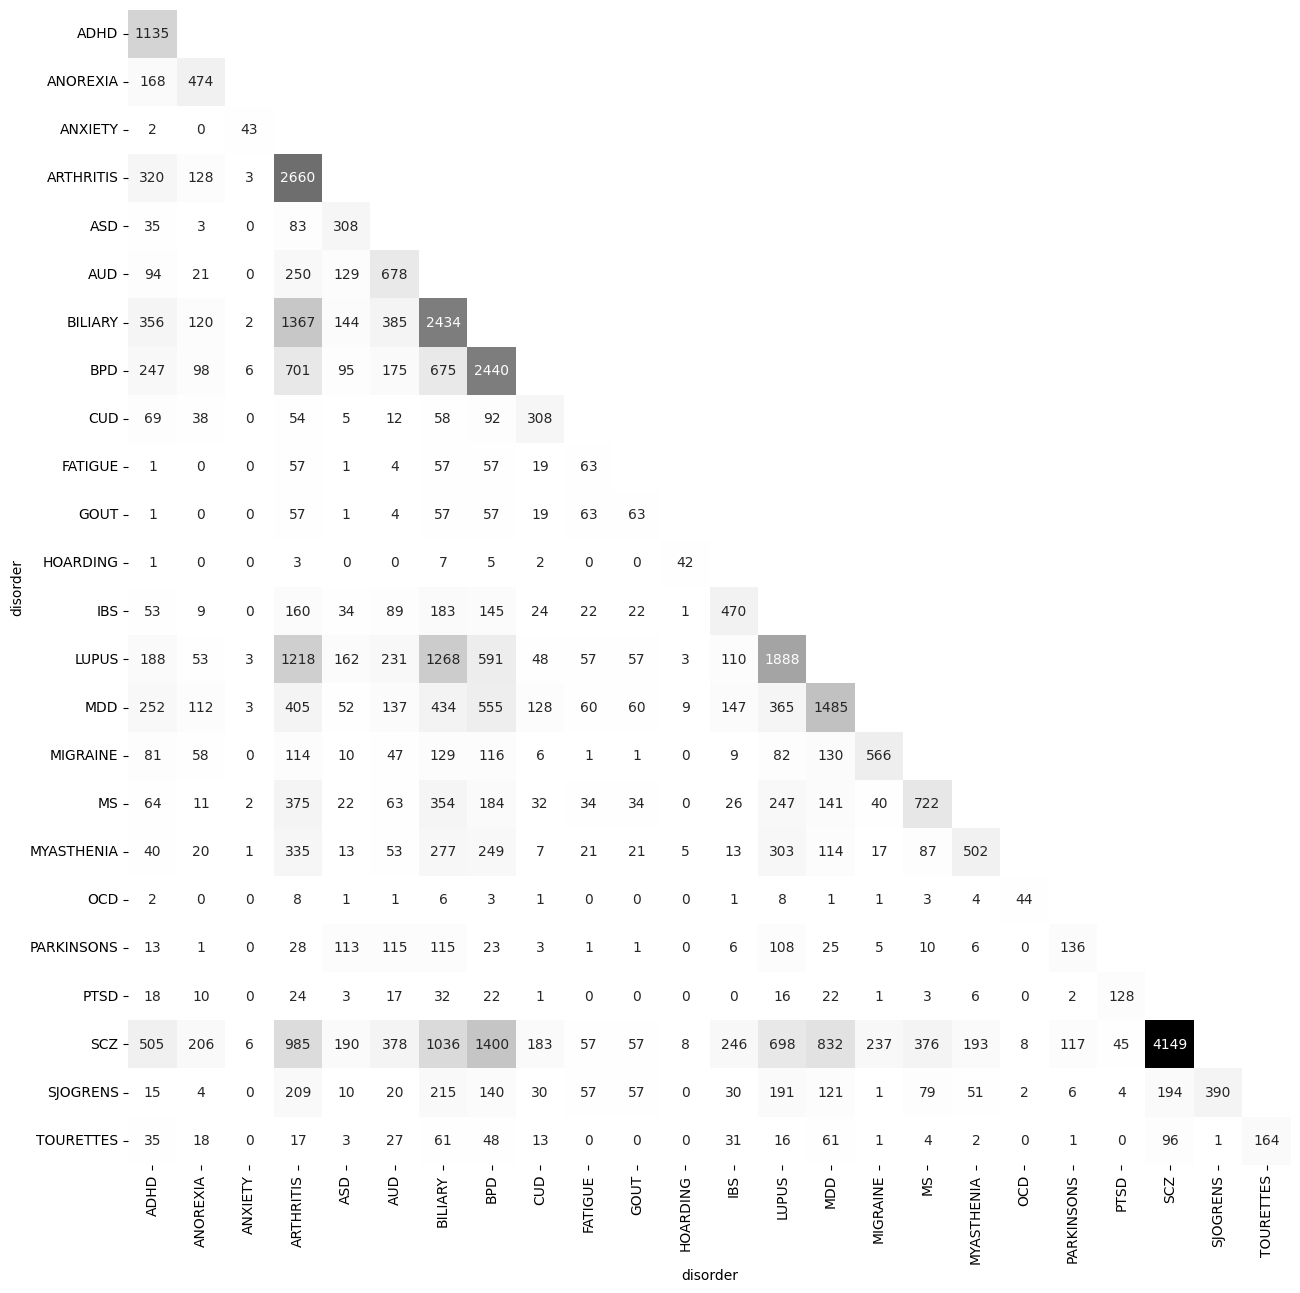

In [24]:
# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(shared_genes), k=1).astype(bool)

# Set the values in the upper triangular part to NaN
shared_genes[mask] = np.nan

# Specify the size of the heatmap
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the heatmap
sns.heatmap(shared_genes, annot=True, fmt='.0f', cmap='Greys', cbar=False)
plt.show()

In [ ]:
show_snps_overlaps(overlap_snps_psych)


In [ ]:
# function to randomly select a given number of SNPs
def select_snps_randomly(df_list, number_of_snps):
        sampled_dfs = []
        for df in df_list:
            sampled = df.sample(n=number_of_snps, replace=True)
    
            sampled_df = sampled[['rsID', 'disorder']]
            sampled_df.reset_index(inplace=True, drop=True)
            # reset index
            #sampled_df.reset_index()
            sampled_dfs.append(sampled_df)
            
        return sampled_dfs

In [ ]:
#function to make binary matrix with randobly selected snps
def make_random_binary_matrix(number_i, list_of_snps, number_of_snps):
    random_binary_list = []
    for i in range(number_i):
        random = select_snps_randomly(list_of_snps, number_of_snps)
        concatenated_random = pd.concat(random)
    
        binary = concatenated_random.pivot_table(index='rsID', columns='disorder', aggfunc=lambda x: 1, fill_value=0)
        random_binary_list.append(binary)
    return random_binary_list


In [ ]:
normalized_matrix = genes_binary.div(genes_binary.sum(axis=1), axis=0)
# Perform hierarchical clustering
linkage_matrix = sch.linkage(genes_binary, method='ward', metric='euclidean')

# Plot the dendrogram
sns.clustermap(genes_binary, method='ward', metric='euclidean', cmap='viridis')
plt.show()

In [ ]:
# all_linkage = []
# 
# for i in range(10):
    
    
transposed = genes_binary.T

clusters = sch.linkage(transposed, method='average', metric='euclidean')
# all_linkage.append(clusters)
#Plot the dendrogram for disorders
plt.figure(figsize=(12,8))
plt.title('Hierarchical Clustering Dendrogram for Disorders')
plt.xlabel('Disorders')
plt.ylabel('Distance')
sch.dendrogram(clusters, labels=transposed.index, leaf_rotation=90, leaf_font_size=12)
plt.tight_layout()
plt.show()

In [ ]:
# # Compute the consensus linkage matrix
# consensus = np.average(all_linkage, axis=0)  
# 
# # Plot the consensus dendrogram
# plt.figure(figsize=(10, 6))
# plt.title('Consensus Dendrogram')
# plt.xlabel('Disorders')
# plt.ylabel('Distance')
# hierarchy.dendrogram(consensus,labels=psych_names,  leaf_rotation=90, leaf_font_size=14)
# plt.tight_layout()
# plt.show()

In [5]:
finngen = pd.read_csv('FinnGen/FinnGen_table_all_diseases.csv', sep=';', index_col=0)

In [6]:
disorder_list = finngen.index.values.tolist()

In [7]:

fin_matrix = finngen.to_numpy()

In [ ]:
fin_matrix

In [ ]:
print(fin_matrix.shape)

In [14]:



def hypergeometric_prob(matrix, disorder_list, N):

    matrix_shape= matrix.shape
    prob_matrix = np.zeros(matrix_shape)

    for i in range(1, matrix_shape[0]):
        for j in range(i):
            x =matrix[i,j]
            M = matrix[j,j]
            n = matrix[i, i]
            #print(M,n,x)
            if M > n:
                prob = hypergeom.sf(x, N, n, M)
                #print('M>n')
            else:
                prob = hypergeom.sf(x, N, M, n)
                #print('n>M')
                
            prob_matrix[i,j] = prob

    return pd.DataFrame(prob_matrix, columns=disorder_list, index=disorder_list)

   

In [26]:
disorders = shared_genes.columns.tolist()
disorder_matrix = shared_genes.to_numpy()
print(disorder_matrix.shape)


(24, 24)


In [15]:
finngen_p = hypergeometric_prob(fin_matrix,disorder_list, 500000)
#prob_genes=hypergeometric_prob(disorder_matrix, disorders, 20000)

In [45]:
prob_genes

,ADHD,ANOREXIA,ANXIETY,ARTHRITIS,ASD,AUD,BILIARY,BPD,CUD,FATIGUE,...,MDD,MIGRAINE,MS,MYASTHENIA,OCD,PARKINSONS,PTSD,SCZ,SJOGRENS,TOURETTES
ADHD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
ANOREXIA,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
ANXIETY,0.358361,0.250900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
ARTHRITIS,1.000000,1.000000,0.039585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
ASD,0.993967,0.011013,0.409267,0.999982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
AUD,1.000000,0.519524,0.136456,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
BILIARY,1.000000,1.000000,0.021205,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
BPD,1.000000,0.995752,0.436995,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
CUD,1.000000,1.000000,0.409267,0.499084,0.390951,0.359795,0.906453,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
FATIGUE,0.043011,0.131705,0.834240,1.000000,0.627810,0.844896,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0


<Axes: >

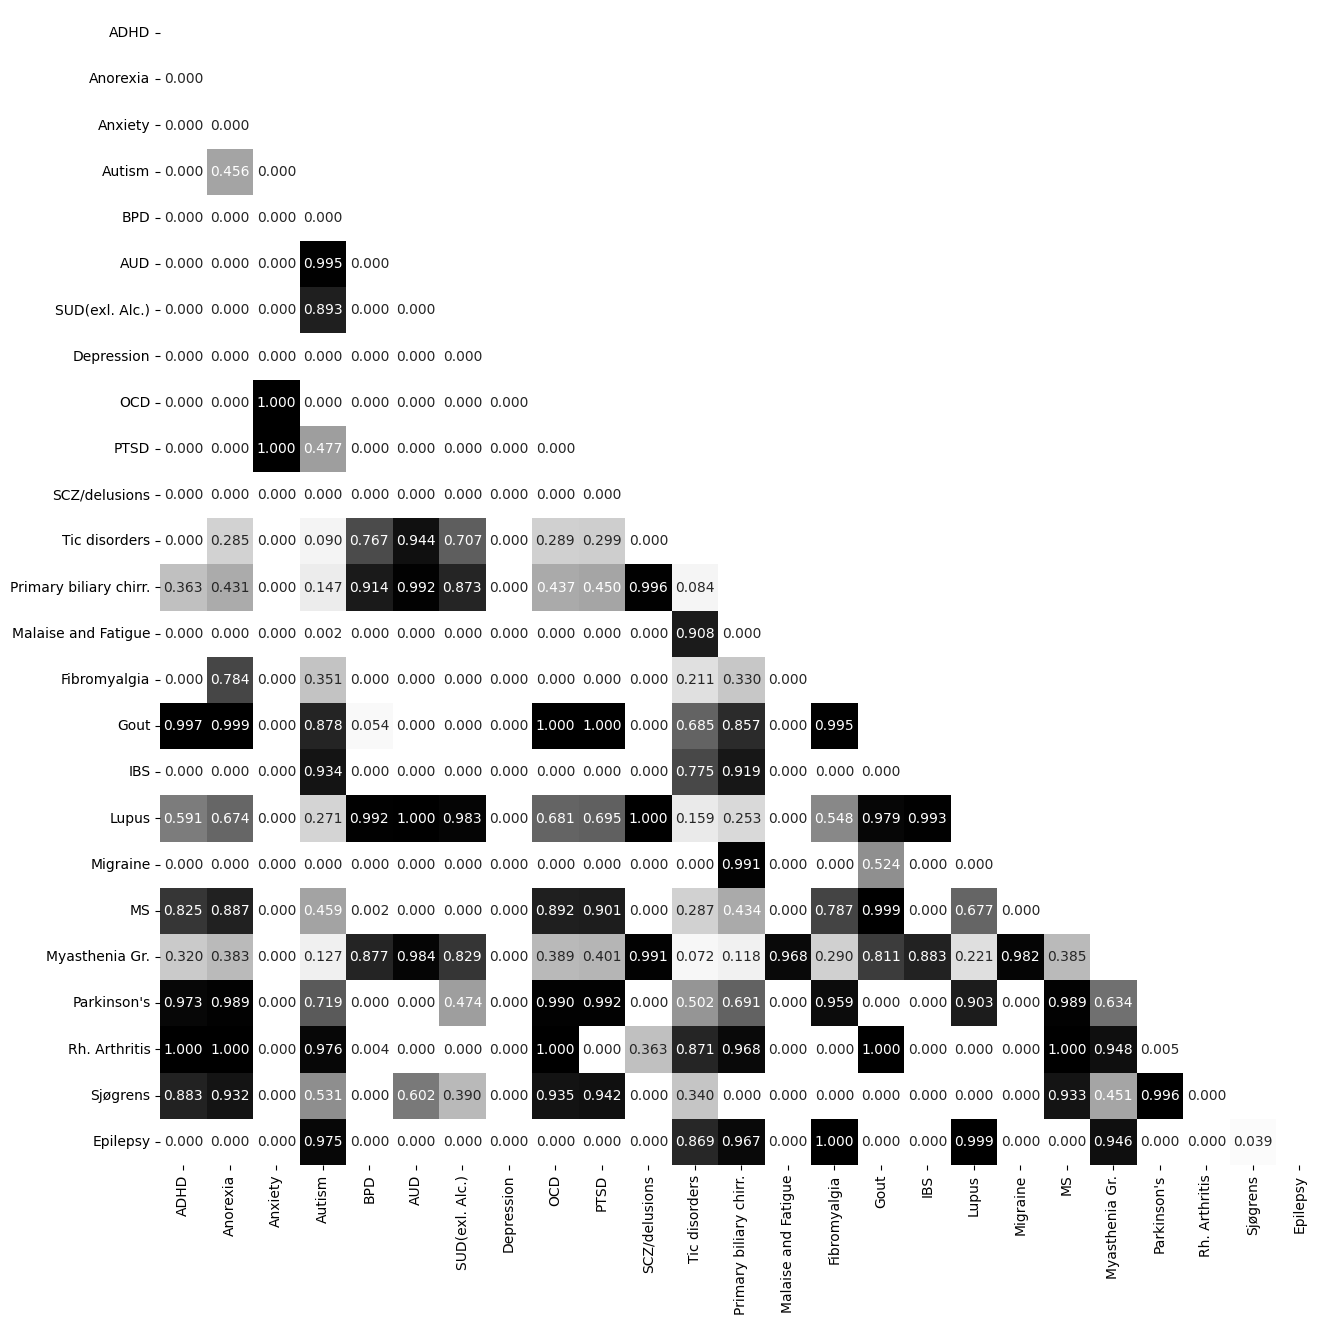

In [16]:
 #specify size of heatmap
# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(finngen_p, dtype=bool))

# Set the upper triangular part to NaN to exclude it from the plot
finngen_p = finngen_p.mask(mask)


fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(finngen_p, annot=True,fmt='.3f',cmap='Greys', cbar=False)
